# ASTRON C161 Final Project
### Aji Nanda, Evan Imata
---

In [2661]:
import numpy as np
from datetime import datetime
from scipy import constants as consts
import matplotlib.pyplot as plt
import scipy.optimize as opt
from matplotlib.animation import FFMpegWriter
metadata = dict(title='Simulation', artist='Matplotlib',comment='Oh my')
writer = FFMpegWriter(fps=15, metadata=metadata)

## 1) Setting Up
---

### 1.1: Defining constants

In [2662]:
# Constants
G = consts.G
c = consts.c
solar_radius = 6.957e8
solar_mass = 1.989e30
stellar_radius = solar_radius
stellar_mass = solar_mass
bh_mass = 4.1e6*stellar_mass # Mass of SMBH Sagittarius A
bh_mass = 5*solar_mass
N_swarm = 10000 # number of swarm particles
ms = stellar_mass/N_swarm

### 1.2: Useful functions + classes

In [2663]:
def to_cart(r, theta, convert=True):
    '''Convert set of polar coordinates to cartesian
    The conversion parameter automatically assumes 
    that you need to convert the pixel units
    and will divide the r values by 3e8'''
    global conversion
    if convert:
        r = np.copy(r)
        r/=conversion
    return r*np.cos(theta), r*np.sin(theta)

def to_polar(x, y):
    '''Convert polar coordinates to cartesian'''
    return np.sqrt(x**2 + y**2), np.arctan(y/x)

def sch_radius(M):
    '''Calculate the schwarzchild radius for a given M mass black hole'''
    global G, c
    return 2*G*M / c**2

def tidal_radius(m, M, r_star):
    '''Calculate the tidal radius, given a star and a black hole'''
    return (M/m)**(1/3) * r_star

def calc_dr_dtau(E, L, r, m=stellar_mass, M=bh_mass):
    '''Calculate dr/dtau'''
    global N_swarm
#     m /= N_swarm
    rs = sch_radius(M)
    p1 = E**2 / (m**2 * c**2)
    p2 = (L**2 / (m**2 * r**2)) * (1-(rs/r))
    p3 = c**2 * (1-(rs/r))
    return (p1-p2-p3)**(0.5)

def EN(E, ms=ms):
    global c
    return ((E/(ms*c**2))**2 - 1) * ms*c**2 / 2

def calc_dr_dtau_2(en, ms, M, rs):
    global G
    return np.sqrt(2*(en+(G*M*ms/rs))/ms)

def energy(v, r, m, M):
    '''Calculate the Lagrangian'''
    global G
    return 0.5*m*v**2 - (-G*M*m/r)
    
def ang_momentum(m, v, b):
    return m*v*b

def scale_up(rs):
    global conversion
    return np.copy(rs) * conversion

def drdt(E, L, r):
    a = (1-(r_sch/rs))
    return ((rs-rt) / (np.abs(rs-rt))) * ((E**2 / (ms**2 * c**2)) - ((L**2 * a) / (ms**2 * rs**2)) + (c**2 * a))**0.5

## 2) Initialization of Variables
---

Get the tidal radius via $r_T = (\frac{M_{\text{bh}}}{M_{\text{star}}})^{1/3} R_{\text{star}}$

In [2664]:
dtau = 0.001
rt = tidal_radius(stellar_mass, bh_mass, stellar_radius)
conversion = rt/3 + (0.1*rt/3) # One graphpixel corresponds to this many meters, which was calculated based on the tidal radius

In [2665]:
print('{:.3e}'.format(conversion))

4.362e+08


Swarm initiation

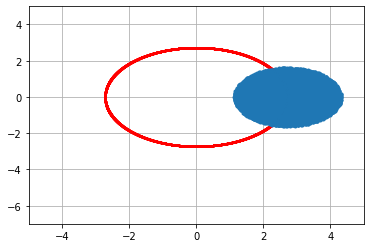

In [2666]:
b = rt # + (0.1*rt) # impact parameter, a little bigger than tidal radius
swarm = np.random.uniform(rt-stellar_radius, rt+stellar_radius, N_swarm-1)

# Initial coordinates of the star in cartesian (b/c it's easier to work with)
np.random.seed(2023)
rs = np.append(b, swarm) # an array of starting radius (r) positions
y_dis = 0 # y displacement
init_xs = rs/conversion
init_ys = np.random.uniform(-stellar_radius/conversion-y_dis, stellar_radius/conversion-y_dis, N_swarm)

# Edit the star so that it's a circle, like in Burkhard's class
circle = lambda x, y, r: np.sqrt((x-(rt/conversion))**2 + (y+y_dis)**2) <= r
idxs = np.where(circle(init_xs,init_ys,stellar_radius/conversion))[0]
init_xs = init_xs[idxs]
init_ys = init_ys[idxs]

rt_phis = np.linspace(0, 2*np.pi, 100000)
rt_rs = np.ones(100000)*rt
xx, yy = to_cart(rt_rs, rt_phis)
plt.plot(xx, yy, '.', color='red', markersize=1)

rs, phis = to_polar(init_xs, init_ys)
rs = scale_up(rs)
plt.plot(init_xs, init_ys, '.')
plt.ylim(-7,5)
plt.xlim(-5,5)
plt.grid(True)

### 2.1: $\frac{d\phi}{d\tau}$
* Initiate all particles with the velocity of the center point, which is in a circular orbit
    * $v = \sqrt{\frac{2GM}{r}}$
    * $v^2 = v_r^2 + v_\phi^2$
    * From our starting point, $v = v_\phi$
    * Thus, $v_\phi = \frac{d\phi}{d\tau} = \sqrt{\frac{2GM}{r}}$

In [2667]:
m = stellar_mass
M = bh_mass
b = rt # + (0.1*rt) # impact parameter, a little bigger than tidal radius
dphi_dtau = np.sqrt(2*G*M/rt)
dphi_dtau

1056365.6019455974

### 2.2: Energy
* We initiate all particles with the same velocity; however, they all have different radii from the black hole. We calculate the energy of all points using the Lagrangian
    * $E = \frac{1}{2}mv_\phi^2 - \frac{GMm}{r}$
        * Where m is the mass of every particle (solar mass divided by number of swarm particles)

In [2668]:
Es = 0.5*ms*dphi_dtau**2 - (G*M*ms/rs)
Es

array([ 2.32988121e+36, -7.17675760e+36,  1.45068472e+37, ...,
        2.32183646e+37,  2.49156832e+37, -1.20664217e+37])

### 2.3: Angular Momentum
* Using the previously calculated E values, the angular momentums for each particle can now be solved by rearranging the Schwarzchild Metric when $\frac{dr}{d\tau} = 0$:
    * $L = [\frac{E^2 r^2}{(1-\frac{r_s}{r})c^2} - m^2c^2r^2]^{1/2}$

In [2669]:
Ls = ((Es**2 * rs**2 / ((1-(r_sch/rs)))) - (ms**2 * c**2 * rs**2))**0.5

/var/folders/44/p2_ff2f90sl05kvyytv51rq00000gn/T/ipykernel_3949/208099760.py:1: RuntimeWarning: invalid value encountered in sqrt
  Ls = ((Es**2 * rs**2 / ((1-(r_sch/rs)))) - (ms**2 * c**2 * rs**2))**0.5


* Now, we can recalculate a new $\frac{d\phi}{d\tau}$ using the constant of motion L
    * $\frac{d\phi}{d\tau} = \frac{L}{mr^2}$
        * Where m again is the mass per swarm particle

In [2670]:
dphi_dtau = Ls / (ms*rs**2)

## 3) Simulation
---
* Red line on plot shows the tidal radius

/var/folders/44/p2_ff2f90sl05kvyytv51rq00000gn/T/ipykernel_3949/14452227.py:57: RuntimeWarning: invalid value encountered in sqrt
  return ((rs-rt) / (np.abs(rs-rt))) * ((E**2 / (ms**2 * c**2)) - ((L**2 * a) / (ms**2 * rs**2)) + (c**2 * a))**0.5
/var/folders/44/p2_ff2f90sl05kvyytv51rq00000gn/T/ipykernel_3949/14452227.py:57: RuntimeWarning: invalid value encountered in sqrt
  return ((rs-rt) / (np.abs(rs-rt))) * ((E**2 / (ms**2 * c**2)) - ((L**2 * a) / (ms**2 * rs**2)) + (c**2 * a))**0.5
/var/folders/44/p2_ff2f90sl05kvyytv51rq00000gn/T/ipykernel_3949/14452227.py:57: RuntimeWarning: invalid value encountered in sqrt
  return ((rs-rt) / (np.abs(rs-rt))) * ((E**2 / (ms**2 * c**2)) - ((L**2 * a) / (ms**2 * rs**2)) + (c**2 * a))**0.5
/var/folders/44/p2_ff2f90sl05kvyytv51rq00000gn/T/ipykernel_3949/14452227.py:57: RuntimeWarning: invalid value encountered in sqrt
  return ((rs-rt) / (np.abs(rs-rt))) * ((E**2 / (ms**2 * c**2)) - ((L**2 * a) / (ms**2 * rs**2)) + (c**2 * a))**0.5
/var/folders/44/

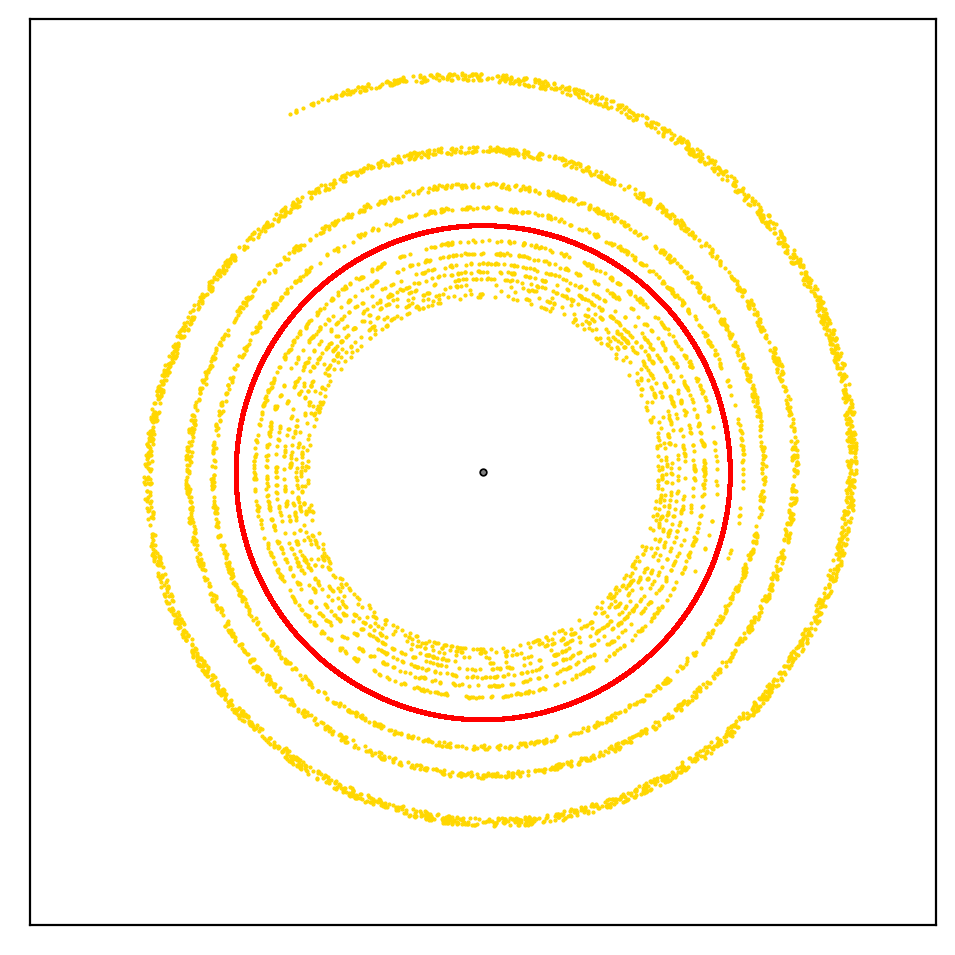

In [2671]:
fig = plt.figure(figsize=(12.,6.), dpi=200)
iterations = 200
view = 5

# Tidal radius circle
rt_phis = np.linspace(0, 2*np.pi, 100000)
rt_rs = np.ones(100000)*rt
xt, yt = to_cart(rt_rs, rt_phis)

r_sch_phis = np.linspace(0, 2*np.pi, 100000)
r_sch_rs = np.ones(100000)*3*sch_radius(bh_mass)
xsch, ysch = to_cart(r_sch_rs, r_sch_phis)

with writer.saving(fig, str(datetime.now()) + ".mp4", dpi=200):
    for i in range(iterations):
        # Update graph
        plt.clf()
        x, y = to_cart(rs, phis)
        plt.plot(x, y, '.', markersize=1, color='gold')
        plt.plot(0, 0, '.', markersize=4, color='black')
        # Tidal radius
        plt.plot(xt, yt, '.', color='red', markersize=1)
        plt.plot(xsch, ysch, '.', color='gray', markersize=0.5)
        plt.xlim(-view,view)
        plt.ylim(-view,view)
        plt.gca().set_aspect('equal')
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        # Update derivatives
        dphi = Ls / (ms*rs**2) * dtau
        # Update coordinates
        phis += dphi
        if i==0:
            rs -= G*M/rs**2 * dtau
        else:
            dr = drdt(E, L, rs) * dtau
            rs += dr
        
        # Update animation
        writer.grab_frame()